In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
file_path = r"C:\Users\shara\OneDrive\Desktop\ML ACTS\projects ml\svm\svm_heartdataset_new_encoded.csv"
df = pd.read_csv(file_path)

print(df.head())
print(df.info())
print(df.describe())
print("\n\nMissing values:\n\n", df.isnull().sum())
print("\nOutcome distribution:\n", df['HeartDisease'].value_counts())


   HeartDisease    BMI  PhysicalHealth  MentalHealth  SleepTime  \
0             0  16.60               3            30          5   
1             0  20.34               0             0          7   
2             0  26.58              20            30          8   
3             0  24.21               0             0          6   
4             0  23.71              28             0          8   

   PhysicalHealth.1  MentalHealth.1  
0                 3              30  
1                 0               0  
2                20              30  
3                 0               0  
4                28               0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5620 entries, 0 to 5619
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   HeartDisease      5620 non-null   int64  
 1   BMI               5620 non-null   float64
 2   PhysicalHealth    5620 non-null   int64  
 3   MentalHealth      5620 

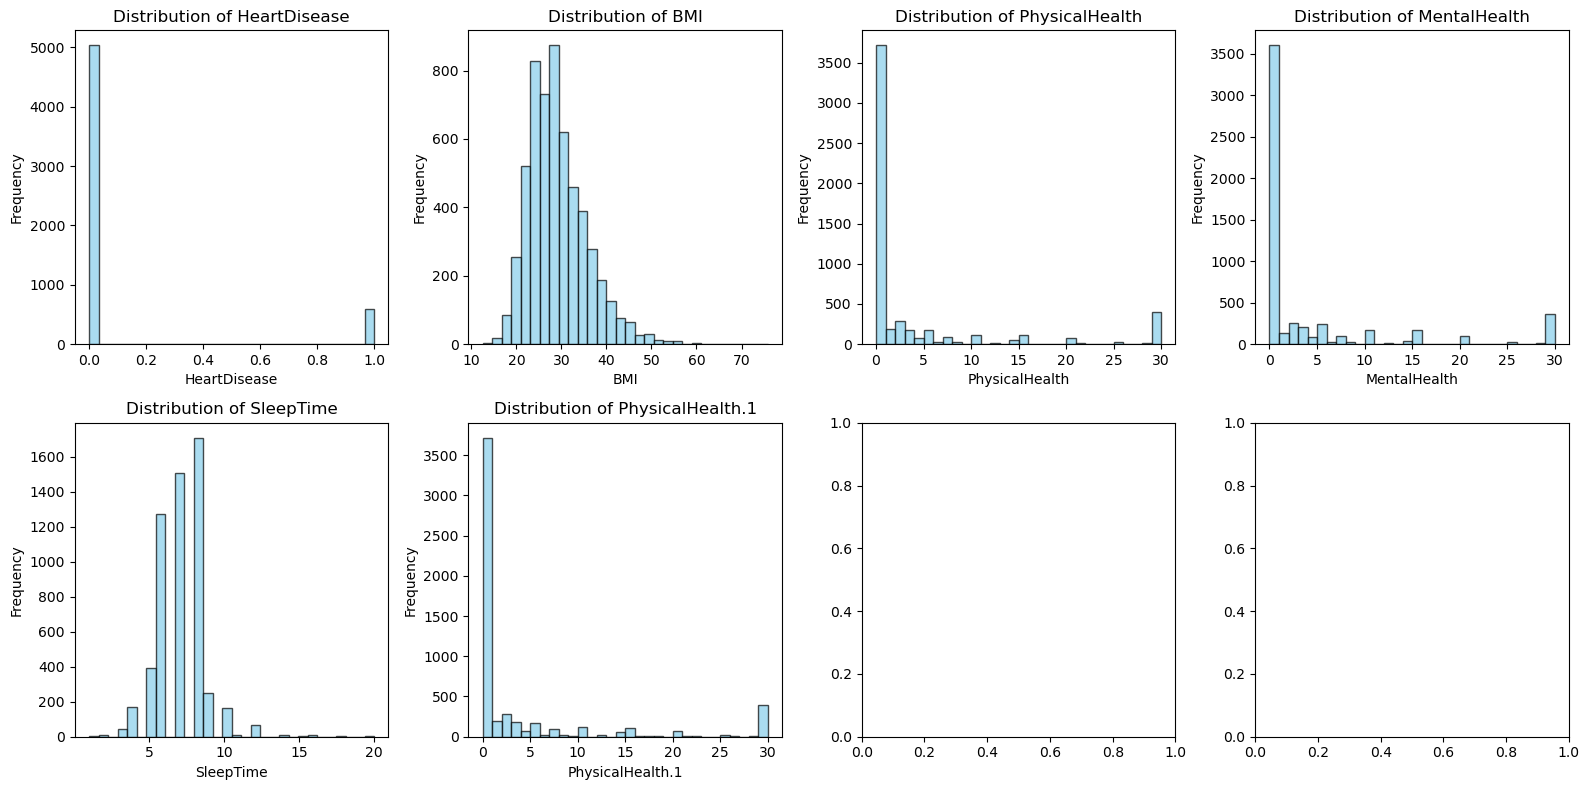

In [4]:
 #    Histplot for all features

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
features = df.columns[:-1]  # All columns except 'HeartDisease'
for i, feature in enumerate(features):
    row = i // 4
    col = i % 4
    axes[row, col].hist(df[feature], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    axes[row, col].set_title(f'Distribution of {feature}')
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

In [5]:
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)
train = df_shuffled.iloc[:3000]
test = df_shuffled.iloc[3000:5600]
print(f"Train set shape: {train.shape}")
print(f"Test set shape: {test.shape}")
X_train = train.iloc[:, :-1].values  # numpy array 
y_train = train.iloc[:, -1].values #Separates feature col (all except last - output ) 
X_test = test.iloc[:, :-1].values
y_test = test.iloc[:, -1].values
print(f"\nX_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


Train set shape: (3000, 7)
Test set shape: (2600, 7)

X_train shape: (3000, 6)
y_train shape: (3000,)
X_test shape: (2600, 6)
y_test shape: (2600,)


In [6]:
#feature scaling (standardization)
# Calculate mean and standard deviation of training features column-wise
train_mean = np.mean(X_train, axis=0)
train_std = np.std(X_train, axis=0)
X_train_scaled = (X_train - train_mean) / train_std
X_test_scaled = (X_test - train_mean) / train_std
print(f"Train mean: {np.mean(X_train_scaled, axis=0)}")
print(f"Train std: {np.std(X_train_scaled, axis=0)}")

Train mean: [ 1.95399252e-17 -4.61852778e-17  9.59232693e-17  4.14483263e-17
 -2.46321482e-16  9.59232693e-17]
Train std: [1. 1. 1. 1. 1. 1.]


In [ ]:
class SVM_classifier():
    def __init__(self, learning_rate, epochs, lambda_parameter): 
        #epoch - no of times model read entire training dataset
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.lambda_parameter = lambda_parameter # controls regularization (penalty on large weights to reduce overfitting).
        self.loss_curve = []
    def fit(self, X, Y):
        self.m, self.n = X.shape
        self.w = np.zeros(self.n)
        self.b = 0
        self.X = X
        self.Y = Y
        for i in range(self.epochs):
            self.update_wb()        # Calculate hinge loss + regularization for tracking
            y_label = np.where(self.Y <= 0, -1, 1)       #means svm asks y(x.w-b)>=1 then classify in +ve class else -ve class  and  # where Converts labels Y to ±1 format because SVM traditionally uses labels -1 and +1 for two classes.
            distances = 1 - y_label * (np.dot(self.X, self.w) - self.b)
            distances = np.maximum(0, distances)       # for hinge loss calculation max(0,pt se line ka dist) #is designed to maximize the margin between classes by penalizing misclassified points ,  #points that are correctly classified but too close to the decision boundary. 
            hinge_loss = np.mean(distances)        #L(y,f(x))=max (0,1- y.f(x)))
            reg_loss = self.lambda_parameter * np.dot(self.w, self.w)   #Regularization is a machine learning technique that prevents models from becoming too complex and overfitting the training data
            total_loss = hinge_loss + reg_loss      #this is ridge l2 regularization as w^2 (and other is lasso l1 regularization as |w|)
            self.loss_curve.append(total_loss)
    def update_wb(self):
        y_label = np.where(self.Y <= 0, -1, 1)   # Convert labels Y to -1/+1 for SVM math
        for index in range(len(self.X)):
            x_i = self.X[index]    
            condition = y_label[index] * (np.dot(x_i, self.w) - self.b) >= 1     # Margin condition: is point correctly classified (with margin)?
            if condition:           #(m= y_i (w·x_i - b)),, if m>=1 at least distance 1 and correctly classified , margin not violated and hinge loss =0
                dw = 2 * self.lambda_parameter * self.w      # Only regularization gradient applies when margin is satisfied
                db = 0        # No update to bias if sample is well classified
            else: 
                dw = 2 * self.lambda_parameter * self.w - np.dot(x_i, y_label[index])    # If margin violated, apply hinge loss & regularization gradients
                db = y_label[index]      # Correct bias in direction of actual label to improve separation
            
            self.w -= self.learning_rate * dw  
            self.b -= self.learning_rate * db  

    def predict(self, X):
        output = np.dot(X, self.w) - self.b
        predicted_labels = np.sign(output)      #-1(-ve class-means -ve side of hyperplane) if output>o and +1(+ve class)if output<0 labels defined for SVM classes wrt hyperplane
        y_hat = np.where(predicted_labels <= -1, 0, 1)
        return y_hat     #0 and 1 labels

In [8]:
# Real datasets use 0/1 labels
# SVM math needs -1/+1 labels
# Convert for correct math/output - accuracy(evaluation)  expects 0,1

In [9]:
print("Training SVM model...")
model = SVM_classifier(learning_rate=0.001, epochs=1000, lambda_parameter=0.01)
model.fit(X_train_scaled, y_train)
print("Model training completed!")

Training SVM model...
Model training completed!


In [10]:
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

In [11]:
def calculate_metrics(y_true, y_pred):
    tp = np.sum((y_pred == 1) & (y_true == 1)) # true positive 
    fp = np.sum((y_pred == 1) & (y_true == 0)) #false positive
    tn = np.sum((y_pred == 0) & (y_true == 0)) # true negative
    fn = np.sum((y_pred == 0) & (y_true == 1)) # false negative
    accuracy = (tp + tn) / (tp + fp + tn + fn) # overall accuracy formula for classification svm
    return {'accuracy': accuracy}
train_metrics = calculate_metrics(y_train, y_pred_train)
test_metrics = calculate_metrics(y_test, y_pred_test)
print(f"Accuracy on train :  {train_metrics['accuracy']:.4f}")
print(f"Accuracy on test :  {test_metrics['accuracy']:.4f}")


Accuracy on train :  0.9670
Accuracy on test :  0.9583


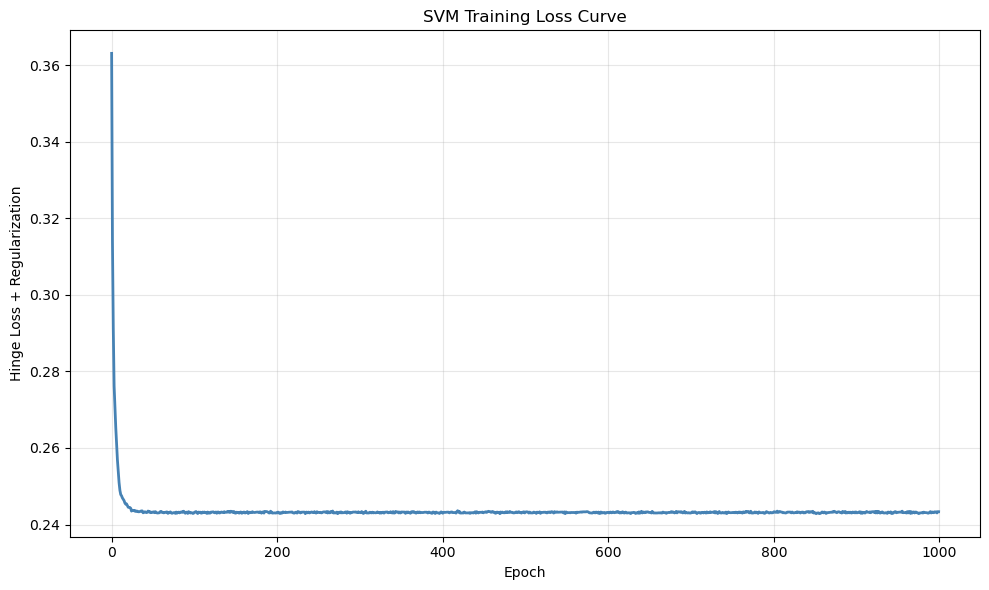

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(model.loss_curve, linewidth=2, color='steelblue')
plt.xlabel('Epoch')
plt.ylabel('Hinge Loss + Regularization')
plt.title('SVM Training Loss Curve')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#StableLoss The curve is mostly flat, meaning the algorithm has converged.
#NoiseNormal Small oscillations are normal due to stochastic updates—no major trends shown.
#NoOverfitting Loss does not jump or diverge, showing regularization and learning rate are effective.

In [14]:
tp = np.sum((y_pred_test == 1) & (y_test == 1))
fp = np.sum((y_pred_test == 1) & (y_test == 0))  
tn = np.sum((y_pred_test == 0) & (y_test == 0))  
fn = np.sum((y_pred_test == 0) & (y_test == 1))  
print(f"True Negatives (TN): {tn}")#True Negative (TN): False, predicted as false
print(f"False Positives (FP): {fp}")#False Positive (FP): False, predicted as true
print(f"False Negatives (FN): {fn}")#False Negative (FN): True, predicted as false
print(f"True Positives (TP): {tp}") #True Positive (TP): True, predicted as true

# shows that tn fn fp tp which our model predicts  , 
# helps identify if the model is biased towards one class ,  
# useful for imbalanced dataset where accuracy can be misleading

True Negatives (TN): 1654
False Positives (FP): 0
False Negatives (FN): 72
True Positives (TP): 0
